In [28]:
import numpy as np
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
#-- This block is only required on Google Colab
import pandas as pd
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')
%cd '/content/glq_mpia'
#--
import contrastive_utils
import glob
import re
from astropy.io import fits

/content/glq_mpia


In [29]:
def get_fresco_ids(folder_path):
    '''
    Scrapes all fresco FITS file IDs from the given folder.
    Returns a list of ID strings
    '''
    files = glob.glob(folder_path + "/fresco-only-n-v2_*.stack.fits")

    ids = []
    for file in files:
        match = re.search(r'fresco-only-n-v2_(\d+)\.stack\.fits', file)
        if match:
            ids.append(match.group(1))

    return ids

folder = "/content/2dspec/2dspec"
fresco_ids = get_fresco_ids(folder)

print(fresco_ids)

all_fits = []
all_img = []
for ii in range(len(fresco_ids)):
    fit = fits.open("/content/2dspec/2dspec/fresco-only-n-v2_" + str(fresco_ids[ii]) + ".stack.fits")
    img = fit[1].data
    all_fits.append(fit)
    all_img.append(img)

['15518', '13117', '24306', '21160', '28314', '12872', '28501', '05639', '10510', '28931', '03340', '20940', '23769', '05004', '25517', '15537', '01693', '28055', '31880', '24422', '05365', '08184', '24112', '10090', '25203', '15671', '10223', '00683', '00857', '00617', '21495', '26817', '28455', '09007', '11193', '11318', '02607', '15025', '21181', '16683', '07111', '22863', '09825', '28822', '19161', '33491', '04153', '00828', '01367', '28552', '12780', '07196', '06129', '25500', '16921', '30206', '29620', '19796', '11693', '30406', '30286', '19990', '09750', '10092', '33189', '30971', '00849', '32891', '24451', '24367', '12468', '17666', '02654', '29595', '18573', '32858', '32404', '31899', '24157', '19280', '01596', '01200', '01128', '02204', '03317', '12756', '31092', '13444', '16929', '06954', '04699', '21516', '25675', '07436', '24354', '24761', '10135', '11699', '06537', '07527', '14284', '07411', '09040', '26024', '01160', '05233', '12285', '25405', '26759', '32260', '31923', 

In [31]:
print(all_img[0].shape)
all_img_copy = np.array(all_img)[..., np.newaxis]
print(all_img_copy[0].shape)

(64, 630)
(64, 630, 1)


In [32]:
# Loading model
contrastor = contrastive_utils.Contrastor(
    contrastive_utils.load_augmentor(),
    contrastive_utils.load_encoder(),
    contrastive_utils.load_projector(),
    temperature=0.1,
)
# Compiling model
contrastor.compile(
    optimizer=optimizers.SGD(learning_rate=3e-4, momentum=1e-5), run_eagerly=True
)

In [33]:
# Training model
history = contrastor.fit(
    contrastive_utils.normalise_imgs(all_img_copy),
    batch_size=32,
    epochs=100,
    callbacks=[EarlyStopping(
        monitor="loss",
        mode="min",
        patience=5,
        verbose=1,
        min_delta=0.01
    )],
)
contrastor.save_weights('./models/contrastor.weights.h5')

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 599ms/step - loss: 3.5347
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 648ms/step - loss: 3.2509
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 699ms/step - loss: 3.1494
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 594ms/step - loss: 3.1780
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 589ms/step - loss: 3.1514
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 592ms/step - loss: 3.1408
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 599ms/step - loss: 3.0255
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 596ms/step - loss: 2.9984
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - loss: 3.0261
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 613ms/step - loss: 2.9918
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - loss: 3.5956
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - loss: 3.0470
Epoch 12: early stopping


ValueError: You are saving a model that has not yet been built. Try building the model first by calling it on some data or by using `build()`.

In [36]:
# Forward passing the original images in batches
batch_size = 32
all_encoded = []

imgs_normalised = contrastive_utils.normalise_imgs(all_img_copy[:, 3:-3, 3:-3, :])

for i in range(0, len(imgs_normalised), batch_size):
    batch = imgs_normalised[i:i+batch_size]
    encoded_batch = contrastor.encoder(batch).numpy()
    all_encoded.append(encoded_batch)

encoded_imgs = np.concatenate(all_encoded, axis=0)
encoded_imgs = np.array([enc_img / np.linalg.norm(enc_img) for enc_img in encoded_imgs])
np.savez_compressed('./data/processed/encoded_imgs', ids=fresco_ids, encoded_imgs=encoded_imgs)

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [38]:
fl = np.load('./data/processed/encoded_imgs.npz')
ids = fl['ids']
enc_imgs = fl['encoded_imgs']
# hzq_df = pd.read_csv('./data/external/known_hzqs.csv')
# hzq_cois = [coi for coi in hzq_df['COADD_OBJECT_ID']
#            if str(coi) in ids]





In [39]:
embedding = TSNE(n_components=2, perplexity=10).fit_transform(enc_imgs)

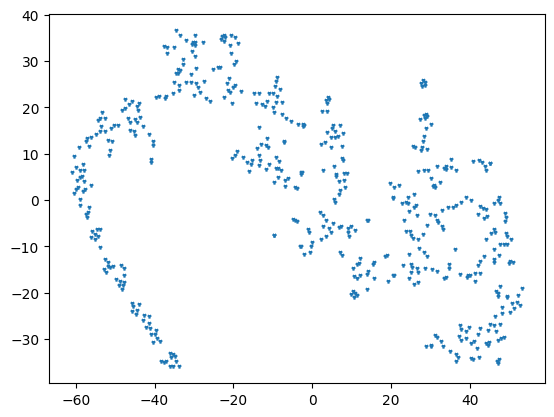

In [40]:
plt.scatter(
    embedding[:,0], embedding[:,1], marker='1', s=10
)
# plt.scatter(
#     [embedding[ids.astype(int)==coi,0] for coi in hzq_cois],
#     [embedding[ids.astype(int)==coi,1] for coi in hzq_cois],
#     marker='+'
# )

In [43]:
import pandas as pd

catalogue = pd.read_csv(
    '/content/FRESCO_O3_emitters_release_v2.txt',  # update path
    comment='#',
    sep='\s+',
    names=['name', 'ra', 'dec', 'q_mean', 'z',
           'flux_HB', 'err_HB', 'flux_4960', 'err_4960',
           'flux_5008', 'err_5008', 'muv', 'muv_84', 'muv_16',
           'f_f444w', 'e_f444w', 'mag_det_img']
)

# Extract numeric ID and zero-pad to 5 digits
catalogue['fits_id'] = catalogue['name'].str.extract(r'(\d+)')[0].astype(int).apply(lambda x: f"{x:05d}")

# Cross-match catalogue against your ids array
# ids is a list of strings like '00169', '00560', etc.
ids_list = list(ids)
catalogue['in_sample'] = catalogue['fits_id'].isin(ids_list)
catalogue['embedding_idx'] = catalogue['fits_id'].apply(lambda x: ids_list.index(x) if x in ids_list else -1)

# Add cluster label and t-SNE coordinates to matched catalogue entries
matched = catalogue[catalogue['in_sample']].copy()
matched['cluster'] = matched['embedding_idx'].apply(lambda x: cluster_labels[x])
matched['tsne_x'] = matched['embedding_idx'].apply(lambda x: embedding[x, 0])
matched['tsne_y'] = matched['embedding_idx'].apply(lambda x: embedding[x, 1])

print(f"{len(matched)} catalogue sources matched out of {len(catalogue)}")
print(matched[['name', 'fits_id', 'z', 'cluster', 'tsne_x', 'tsne_y']].head())

78 catalogue sources matched out of 137
     name fits_id         z  cluster     tsne_x     tsne_y
0  gn_169   00169  7.001321        8   6.047191   5.140318
1  gn_617   00617  7.001321        8  29.503176   6.564219
2  gn_620   00620  6.986952        6  -9.244424  25.750715
3  gn_849   00849  7.601629        6 -30.705124  25.500807
4  gn_857   00857  7.004917        4 -57.397018  12.691859


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2777762259.py:6: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',


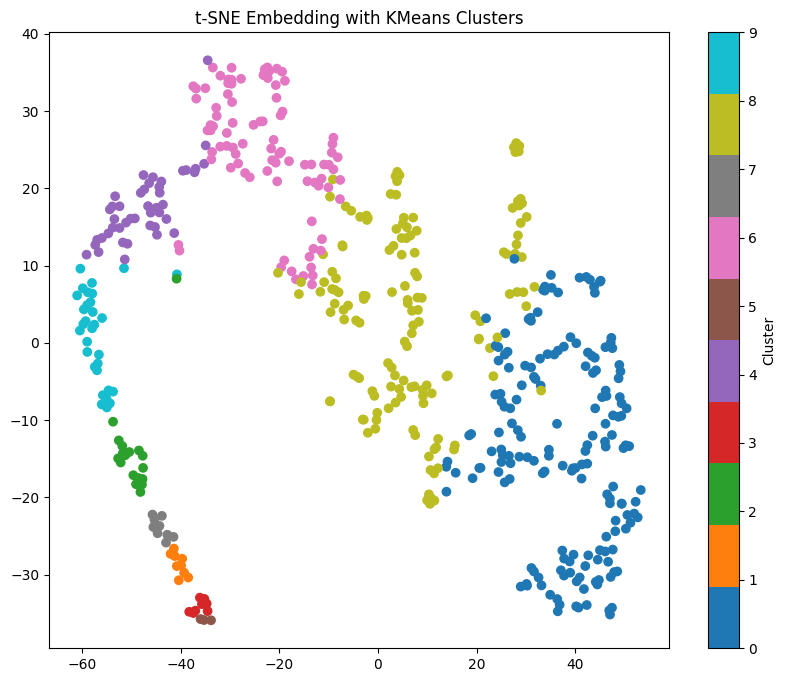

Object ID: 15518, Cluster: 0


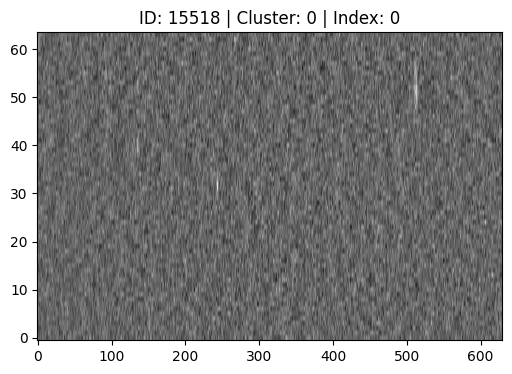

In [41]:
# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(enc_imgs)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='tab10')
plt.colorbar(scatter, ax=ax, label='Cluster')
ax.set_title('t-SNE Embedding with KMeans Clusters')
plt.show()

# Build a dict mapping cluster number -> indices of objects in that cluster
clusters = {i: np.where(cluster_labels == i)[0] for i in range(10)}

def inspect_object(cluster_num, object_idx):
    '''
    cluster_num: which cluster to look in (0-9)
    object_idx: index within that cluster
    '''
    idx = clusters[cluster_num][object_idx]
    obj_id = ids[idx]
    print(f"Object ID: {obj_id}, Cluster: {cluster_num}")

    fits_path = f"/content/2dspec/2dspec/fresco-only-n-v2_{obj_id}.stack.fits"
    fit = fits.open(fits_path)
    img = fit[1].data
    fit.close()

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(img, origin='lower', cmap='gray', aspect='auto')
    ax.set_title(f"ID: {obj_id} | Cluster: {cluster_num} | Index: {object_idx}")
    plt.show()

# Usage:
inspect_object(cluster_num=0, object_idx=0)

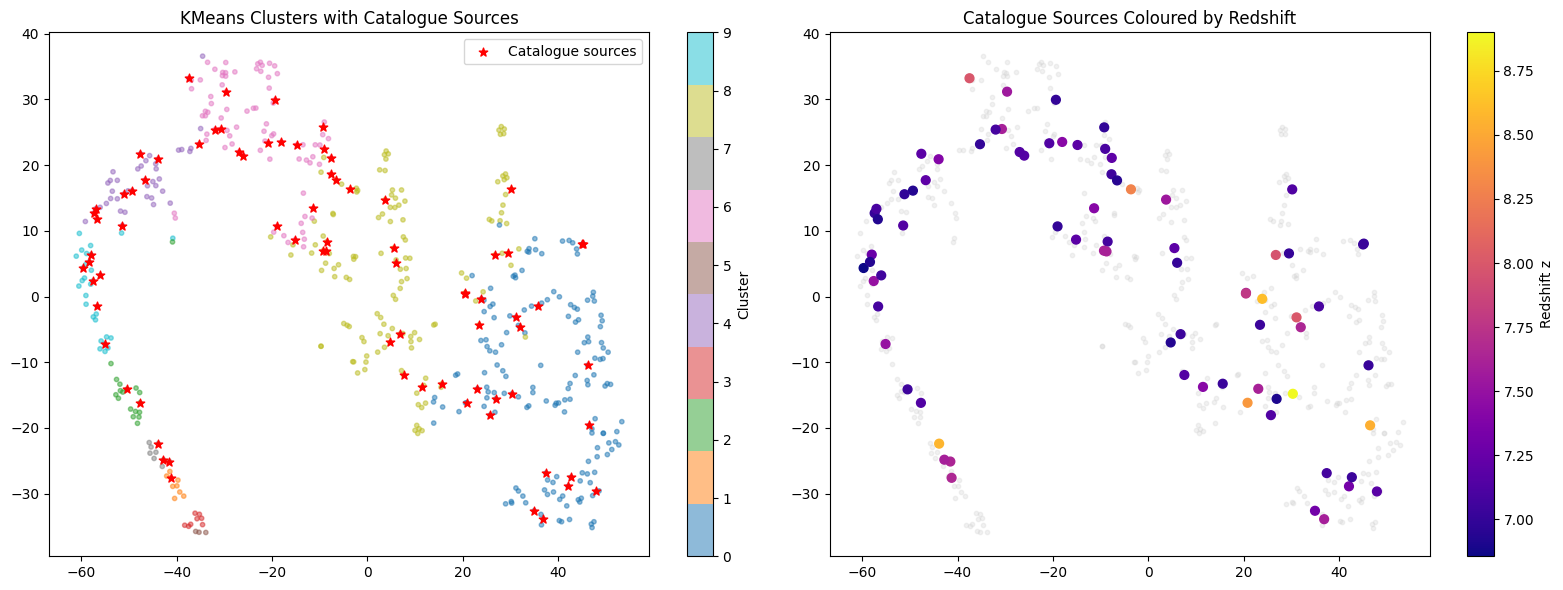

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: all points coloured by cluster
scatter1 = axes[0].scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='tab10', s=10, alpha=0.5)
# Overlay matched catalogue sources
axes[0].scatter(matched['tsne_x'], matched['tsne_y'], c='red', s=40, marker='*', label='Catalogue sources', zorder=5)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].set_title('KMeans Clusters with Catalogue Sources')
axes[0].legend()

# Right: matched sources coloured by redshift
scatter2 = axes[1].scatter(embedding[:, 0], embedding[:, 1], c='lightgray', s=10, alpha=0.3)
sc = axes[1].scatter(matched['tsne_x'], matched['tsne_y'], c=matched['z'], cmap='plasma', s=40, zorder=5)
plt.colorbar(sc, ax=axes[1], label='Redshift z')
axes[1].set_title('Catalogue Sources Coloured by Redshift')

plt.tight_layout()
plt.show()

In [42]:
print(f"Cluster 0 has {len(clusters[0])} objects")
print(f"Object IDs: {ids[clusters[0]]}")

Cluster 0 has 171 objects
Object IDs: ['15518' '28314' '28931' '03340' '23769' '15537' '31880' '05365' '08184'
 '09007' '11318' '16683' '07111' '22863' '19161' '00828' '16921' '29620'
 '19796' '30406' '19990' '33189' '30971' '32891' '24367' '17666' '18573'
 '32858' '32404' '19280' '01200' '01128' '16929' '25675' '07436' '11699'
 '07527' '25405' '21541' '10757' '22772' '29167' '12410' '14402' '24717'
 '24082' '20272' '00990' '20169' '12398' '14594' '24913' '14996' '32048'
 '18529' '16240' '20669' '01843' '01092' '07140' '29919' '08770' '21979'
 '20544' '17431' '24352' '06173' '19381' '22606' '18476' '23089' '15052'
 '20586' '19365' '29802' '09907' '19287' '06587' '22789' '11294' '27138'
 '26216' '12148' '07286' '33419' '23532' '11708' '15147' '14170' '25557'
 '11697' '24416' '07431' '09759' '24395' '19942' '12607' '23968' '15963'
 '26513' '16369' '07062' '16828' '19551' '24629' '10543' '19893' '31200'
 '29624' '16974' '17994' '07322' '20261' '26683' '15004' '15152' '21683'
 '16886' '019

(-15.0, 0.0)

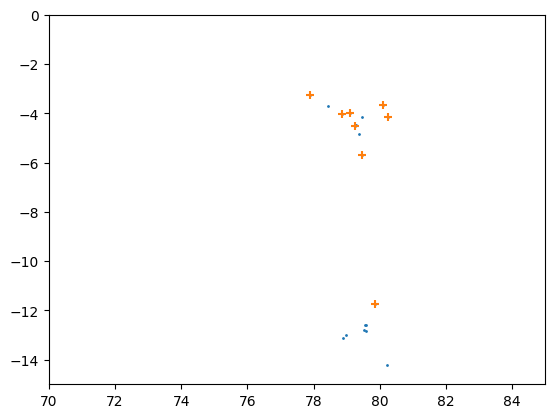

In [ ]:
# plt.scatter(
#     embedding[:,0], embedding[:,1], s=1
# )
# plt.scatter(
#     [embedding[ids.astype(int)==coi,0] for coi in hzq_cois],
#     [embedding[ids.astype(int)==coi,1] for coi in hzq_cois],
#     marker='+'
# )
# plt.xlim(70,85) # These limits may need to
# plt.ylim(-15,0) # be adjusted

In [ ]:
np.savez_compressed(
    './data/processed/embedding.npz',
    ids=ids,
    embedding=embedding
)

In [ ]:
quasar_ids = ids[
    (76<embedding[:,0])
    &(embedding[:,0]<82)
    &(-6<embedding[:,1])
    &(embedding[:,1]<0)
]
np.savez_compressed(
    './data/processed/quasar_ids.npz',
    ids=quasar_ids
)
print(quasar_ids)

['1228745162' '1413280997' '1695974542' '1143273115' '1456016600'
 '1599741416' '1096344653' '1513805078' '1271696125' '1197311621'
 '1250552714']
